# 사출성형기 AI 데이터셋
## 1. Minimum Covariance Determinant Method
Minimum Covariance Determinant Method는 데이터의 원소간의 공분산을 반영한 Mahalanobis Distance를 활용해 anomaly detection을 진행하는 방법입니다. 

### 1-1. Loading Package, Data Preprocessing
데이터 셋을 Import하고, 데이터의 품질을 낮추는 행과 열을 제거합니다. 또한, CN7과 RG3 제품을 나누어 분석을 진행하기 위해 데이터를 분리합니다. 

In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.covariance import EmpiricalCovariance, MinCovDet
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import mean_absolute_error

from google.colab import drive
drive.mount('/content/drive')

moldset_labeled = pd.read_csv('/content/drive/My Drive/KUIAI/dataset/moldset_labeled.csv',low_memory=False, index_col=False)

moldset_labeled.drop(columns={'_id', 'TimeStamp', 'PART_FACT_PLAN_DATE', 'PART_FACT_SERIAL',
                              'PART_NAME', 'EQUIP_CD', 'EQUIP_NAME', 'Reason',
                              "Mold_Temperature_1", "Mold_Temperature_2", "Barrel_Temperature_7",
                              "Mold_Temperature_5", "Mold_Temperature_6", "Switch_Over_Position",
                              "Mold_Temperature_7", "Mold_Temperature_8", "Mold_Temperature_9",
                              "Mold_Temperature_10", "Mold_Temperature_11", "Mold_Temperature_12"},inplace=True)

moldset_labeled_cn7 = moldset_labeled[(moldset_labeled['PART_NO']=='86131AA000')|
                                      (moldset_labeled['PART_NO']=='86141AA000')].copy()
moldset_labeled_cn7.drop(columns={'PART_NO'},inplace=True)

moldset_labeled_rg3 = moldset_labeled[(moldset_labeled['PART_NO']=='86131T1000')|
                                      (moldset_labeled['PART_NO']=='86141T1000')].copy()
moldset_labeled_rg3.drop(columns={'PART_NO'},inplace=True)

moldset_labeled_rg3['PassOrFail'] = moldset_labeled_rg3['PassOrFail'].map({0:int(0),1:int(1)}).copy()
moldset_labeled_cn7['PassOrFail'] = moldset_labeled_cn7['PassOrFail'].map({0:int(0),1:int(1)}).copy()

labeled_data = [moldset_labeled_cn7, moldset_labeled_rg3]

Mounted at /content/drive


scikit-learn 패키지의 Standard Scaler 모듈을 활용하여 PassOrFail 열을 제외한 다른 열들의 정규화를 진행합니다. 

In [2]:
from sklearn.preprocessing import StandardScaler

data = [moldset_labeled_cn7, moldset_labeled_rg3]
for d in data:
    for column in d.columns:
        if column != 'PassOrFail':
            sc = StandardScaler()
            d[[column]] = sc.fit_transform(d[[column]])

### 1-2. Dividing into Test set and Training Set.
  
  머신러닝 기법의 활용을 위해 주어진 데이터셋을 Training Set과 Test Set으로 분리합니다. Training Set은 PassOrFail의 값이 0(원래 데이터 셋에서는 Y)인 데이터의 70%를 활용했고, Test Set은 PassOrFail의 값이 1인 데이터와 값이 0인 데이터 중 Training Set에서 활용되지 않은 데이터를 활용하였습니다.

  본 데이터에서 활용하고 있는 데이터 셋은 고차원의 데이터이기 때문에 차원 축소를 진행하는 것이 데이터 분석에 도움이 될 것이라 판단해 주성분 분석을 진행하였습니다. 주성분 분석의 차원의 수는 분산의 약 60%를 설명할 수 있는 3차원으로 결정하였습니다. 

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
from sklearn.ensemble import IsolationForest
clf=IsolationForest(n_estimators=50, max_samples=50, contamination=float(0.004), 
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=None, verbose=0,behaviour="new")
# 50개의 노드 수, 최대 50개의 샘플
# 0.04%의 outlier 색출.
feature_set = moldset_labeled_cn7
clf.fit(feature_set)
pred = clf.predict(feature_set)
feature_set['PassOrFail']=pred
outliers=feature_set.loc[feature_set['PassOrFail']==-1]
outlier_index=list(outliers.index)
print(outlier_index)
#Find the number of anomalies and normal points here points classified -1 are anomalous
print(feature_set['PassOrFail'].value_counts())

In [ ]:
pca = PCA(n_components=3) 
scaler = StandardScaler()
#normalize the metrics
X = scaler.fit_transform(feature_set)
X_reduce = pca.fit_transform(X)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")
# Plot the compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")
# Plot x's for the ground truth outliers
ax.scatter(X_reduce[outlier_index,0],X_reduce[outlier_index,1], X_reduce[outlier_index,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()



In [ ]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(2)
pca.fit(feature_set)
res=pd.DataFrame(pca.transform(feature_set))
Z = np.array(res)
plt.title("IsolationForest")
# plt.contourf( Z, cmap=plt.cm.Blues_r)
b1 = plt.scatter(res[0], res[1], c='green',
                 s=20,label="normal points")
b1 =plt.scatter(res.iloc[outlier_index,0],res.iloc[outlier_index,1], c='green',s=20,  edgecolor="red",label="predicted outliers")
plt.legend(loc="upper right")
plt.show()

In [3]:
df_cn7 = data[0]
pca_cn7 = PCA(n_components=3)
pca_cn7.fit(df_cn7.drop('PassOrFail', axis = 1))
df_pca_cn7 = pd.DataFrame(pca_cn7.transform(df_cn7.drop('PassOrFail' ,axis = 1)))

df_cn7_Y = df_pca_cn7[df_cn7["PassOrFail"]==0]
df_cn7_N = df_pca_cn7[df_cn7["PassOrFail"]==1]

split_cn7 = int(df_cn7_Y.shape[0]*0.7)
df_cn7_train = df_cn7_Y[:split_cn7]
df_cn7_test = pd.concat([df_cn7_N, df_cn7_Y[split_cn7:]])

df_rg3 = data[1]
pca_rg3 = PCA(n_components=3)
pca_rg3.fit(df_rg3.drop('PassOrFail', axis = 1))
df_pca_rg3 = pd.DataFrame(pca_rg3.transform(df_rg3.drop('PassOrFail' ,axis = 1)),index = df_rg3.index)

df_rg3_Y = df_pca_rg3[df_rg3["PassOrFail"]==0]
df_rg3_N = df_pca_rg3[df_rg3["PassOrFail"]==1]

split_rg3 = int(df_rg3_Y.shape[0]*0.7)
df_rg3_train = df_rg3_Y[:split_rg3]
df_rg3_test = pd.concat([df_rg3_N, df_rg3_Y[split_rg3:]])

Text(0, 0.5, 'Percentage of Variance')

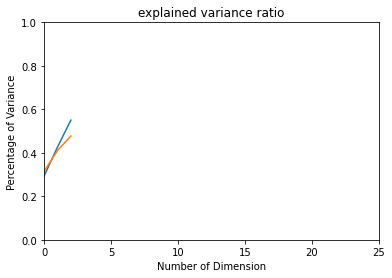

In [4]:
plt.plot(np.cumsum(pca_cn7.explained_variance_ratio_))
plt.plot(np.cumsum(pca_rg3.explained_variance_ratio_))
plt.title("explained variance ratio")
plt.axis([0, 25, 0, 1])
plt.xlabel("Number of Dimension")
plt.ylabel("Percentage of Variance")

### 1-3.1) Building Model - CN7
  Training Set으로 모델을 학습하고 Test Set으로 이를 검증하는 단계입니다. sklearn.covariance 패키지의 EllipticEnvelope 모듈을 활용하여 진행하였습니다. 모집단에서 얼마 만큼의 불량이 섞여있을 지에 대한 확률을 나타내는 값인 Contamination parameter의 경우, 낮은 불량률을 반영하기 위해 0.01로 결정했습니다. 
  학습된 모델을 바탕으로 예측된 값과 Test Set의 기존 Label을 비교합니다. 

In [5]:
start = time.time()

ee_pca_cn7 = EllipticEnvelope(contamination=0.01)
ee_test_cn7 = ee_pca_cn7.fit(df_cn7_train)
df_cn7_res = ee_test_cn7.predict(df_cn7_test)

df_cn7_res[df_cn7_res == 1] = 0
df_cn7_res[df_cn7_res == -1] = 1

print("모델 구축 시간 :", time.time() - start)

모델 구축 시간 : 0.6164727210998535


In [6]:
cn7_pred = pd.Series(df_cn7_res, name = 'PRED', index = df_cn7_test.index)
cn7_real = df_cn7[["PassOrFail"]].loc[df_cn7_test.index]

result = df_cn7_test.join(cn7_pred)
result2 = result.join(cn7_real)
result2

,0,1,2,PRED,PassOrFail
47,-0.458462,2.739100,-0.429316,0,1
80,-0.357765,2.991718,-0.205182,0,1
95,-0.562546,2.647112,-0.284768,0,1
99,-0.287717,2.658136,-0.689211,0,1
101,-0.844373,2.968702,0.069148,0,1
...,...,...,...,...,...
1420,3.129893,-1.644132,-2.445709,0,0
1421,3.039440,-1.452756,-1.580094,0,0
1422,3.039716,-1.453195,-1.580289,0,0
1423,3.040320,-1.680677,-1.972132,0,0


### 1-3.2) Checking Model - CN7
  TP(True Positive), TN(True Negative), FP(False Positive), FN(False Negative)를 계산하고, 이를 바탕으로 계산된 정규화된 Confusion Matrix를 만들고 시각화 하는 과정입니다. 계산된 TP, TN, FP, FN을 바탕으로 Accuracy, Specificity, Precision, F1-score를 계산할 수 있습니다.

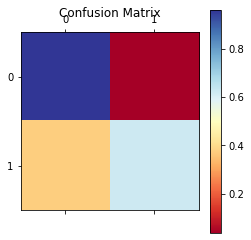

Accuracy    : 0.9485458612975392 
Specificity : 0.37037037037037035 
Precision   : 0.9605568445475638 
F1-score    : 0.972972972972973
모델 검증 시간 : 0.1398024559020996


In [7]:
start = time.time()
TP = (result2['PRED'] == 0) & (result2['PassOrFail'] == 0)
TN = (result2['PRED'] == 1) & (result2['PassOrFail'] == 1)
FP = (result2['PRED'] == 0) & (result2['PassOrFail'] == 1)
FN = (result2['PRED'] == 1) & (result2['PassOrFail'] == 0)

TP = sum(TP)
TN = sum(TN)
FP = sum(FP)
FN = sum(FN)

con = pd.DataFrame([[TP/(TP+FP), FP/(TP+FP)],
                    [FN/(TN+FN), TN/(TN+FN)]])

Acc = (TP+TN)/(TP+FP+FN+TN)
Spe = TN / (TN+FP)
Pre = TP / (TP+FP)
F1 = 2*TP / (2*TP + FP + FN)

def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.RdYlBu):
    plt.matshow(df_confusion, cmap=cmap)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns)
    plt.yticks(tick_marks, df_confusion.index)
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)
    plt.show()
con, plot_confusion_matrix(con)

print(f'Accuracy    : {Acc} \nSpecificity : {Spe} \nPrecision   : {Pre} \nF1-score    : {F1}')
print("모델 검증 시간 :", time.time() - start)

### 1-4.1) Building Model - RG3

In [8]:
start = time.time()
ee_pca_rg3 = EllipticEnvelope(contamination=0.01)
ee_test_rg3 = ee_pca_rg3.fit(df_rg3_train)
df_rg3_res = ee_test_rg3.predict(df_rg3_test)

df_rg3_res[df_rg3_res == 1] = 0 
df_rg3_res[df_rg3_res == -1] = 1
print("모델 구축 시간 :", time.time() - start)

모델 구축 시간 : 0.6106312274932861


In [9]:
rg3_pred = pd.Series(df_rg3_res, name = 'PRED', index = df_rg3_test.index)
rg3_real = df_rg3[["PassOrFail"]].loc[df_rg3_test.index]

result3 = df_rg3_test.join(rg3_pred)
result4 = result3.join(rg3_real)
result4

,0,1,2,PRED,PassOrFail
1561,2.875162,-0.308637,0.164626,0,1
1585,2.454398,0.745367,-1.149192,0,1
1595,1.930597,0.600041,0.811558,0,1
1629,1.481000,0.655135,2.225603,0,1
1669,2.900822,0.469170,0.655104,0,1
...,...,...,...,...,...
2602,-4.254542,-2.091190,1.172650,1,0
2603,-5.025298,-0.724051,0.336758,1,0
2604,-5.026196,-0.724747,0.336338,1,0
2605,-3.508353,-0.634441,-1.065991,1,0


### 1-4.2) Checking Model - RG3

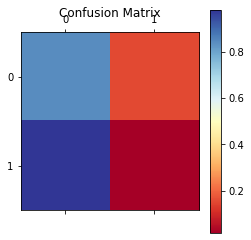

Accuracy    : 0.32171581769436997 
Specificity : 0.16 
Precision   : 0.8467153284671532 
F1-score    : 0.47835051546391755
모델 검증 시간 : 0.1515204906463623


In [10]:
start = time.time()
TP = (result4['PRED'] == 0) & (result4['PassOrFail'] == 0)
TN = (result4['PRED'] == 1) & (result4['PassOrFail'] == 1)
FP = (result4['PRED'] == 0) & (result4['PassOrFail'] == 1)
FN = (result4['PRED'] == 1) & (result4['PassOrFail'] == 0)

TP = sum(TP)
TN = sum(TN)
FP = sum(FP)
FN = sum(FN)

Acc = (TP+TN)/(TP+FP+FN+TN)
Spe = TN / (TN+FP)
Pre = TP / (TP+FP)
F1 = 2*TP / (2*TP + FP + FN)

con = pd.DataFrame([[TP/(TP+FP), FP/(TP+FP)],
                    [FN/(TN+FN), TN/(TN+FN)]])
con, plot_confusion_matrix(con)

print(f'Accuracy    : {Acc} \nSpecificity : {Spe} \nPrecision   : {Pre} \nF1-score    : {F1}')
print("모델 검증 시간 :", time.time() - start)

## 2. AutoEncoder

주어진 데이터셋에서 정상만 가지고 학습한 뒤 정상/비정상을 판단하는 방법입니다. 딥러닝기반의 비지도학습 방법입니다. 

### 2-1. Loading Package, Data Preprocessing

In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import classification_report, precision_score, recall_score,roc_auc_score,accuracy_score,f1_score
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
import tensorflow as tf
from tensorflow.keras import backend as k
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout
from keras.optimizers import SGD
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from tensorflow.keras.optimizers import Adam

In [137]:
moldset_labeled = pd.read_csv('/content/drive/My Drive/KUIAI/dataset/moldset_labeled.csv',low_memory=False, index_col=False)

In [138]:
moldset_labeled.head()

,Unnamed: 0,_id,TimeStamp,PART_FACT_PLAN_DATE,PART_FACT_SERIAL,PART_NO,PART_NAME,EQUIP_CD,EQUIP_NAME,PassOrFail,Reason,Injection_Time,Filling_Time,Plasticizing_Time,Cycle_Time,Clamp_Close_Time,Cushion_Position,Switch_Over_Position,Plasticizing_Position,Clamp_Open_Position,Max_Injection_Speed,Max_Screw_RPM,Average_Screw_RPM,Max_Injection_Pressure,Max_Switch_Over_Pressure,Max_Back_Pressure,Average_Back_Pressure,Barrel_Temperature_1,Barrel_Temperature_2,Barrel_Temperature_3,Barrel_Temperature_4,Barrel_Temperature_5,Barrel_Temperature_6,Barrel_Temperature_7,Hopper_Temperature,Mold_Temperature_1,Mold_Temperature_2,Mold_Temperature_3,Mold_Temperature_4,Mold_Temperature_5,Mold_Temperature_6,Mold_Temperature_7,Mold_Temperature_8,Mold_Temperature_9,Mold_Temperature_10,Mold_Temperature_11,Mold_Temperature_12
0,0,5f8928bb9c0189cc666ef19b,2020-10-16 04:57:47,2020-10-16 오전 12:00:00,24,86141AA000,CN7 W/S SIDE MLD'G RH,S14,650톤-우진2호기,0,None,9.59,4.47,16.92,59.520000,7.13,653.409973,0.0,68.849998,647.98999,55.400002,30.700001,292.5,141.800003,136.800003,37.400002,59.299999,276.500000,274.700012,274.799988,269.200012,255.000000,229.699997,0.0,66.300003,0.0,0.0,24.799999,27.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,5f8928de9c0189cc666ef20b,2020-10-16 04:58:48,2020-10-16 오전 12:00:00,24,86141AA000,CN7 W/S SIDE MLD'G RH,S14,650톤-우진2호기,0,None,9.60,4.48,16.91,59.580002,7.13,653.409973,0.0,68.839996,647.98999,55.299999,30.799999,292.5,141.800003,136.899994,37.500000,59.299999,276.200012,275.500000,275.299988,270.799988,254.699997,229.500000,0.0,67.199997,0.0,0.0,24.799999,27.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5f8928df9c0189cc666ef213,2020-10-16 04:58:48,2020-10-16 오전 12:00:00,23,86131AA000,CN7 W/S SIDE MLD'G LH,S14,650톤-우진2호기,0,None,9.60,4.48,16.91,59.580002,7.13,653.409973,0.0,68.839996,647.98999,55.299999,30.799999,292.5,141.800003,136.899994,37.500000,59.299999,276.200012,275.500000,275.299988,270.799988,254.699997,229.500000,0.0,67.199997,0.0,0.0,24.799999,27.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,5f8928f39c0189cc666ef25e,2020-10-16 04:59:48,2020-10-16 오전 12:00:00,23,86131AA000,CN7 W/S SIDE MLD'G LH,S14,650톤-우진2호기,0,None,9.59,4.48,16.91,59.560001,7.13,653.419983,0.0,68.839996,647.98999,55.299999,31.000000,292.5,141.800003,136.800003,37.500000,59.299999,276.500000,275.000000,275.399994,271.100006,254.899994,230.000000,0.0,66.900002,0.0,0.0,25.000000,27.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,5f8928f59c0189cc666ef265,2020-10-16 04:59:48,2020-10-16 오전 12:00:00,24,86141AA000,CN7 W/S SIDE MLD'G RH,S14,650톤-우진2호기,0,None,9.59,4.48,16.91,59.560001,7.13,653.419983,0.0,68.839996,647.98999,55.299999,31.000000,292.5,141.800003,136.800003,37.500000,59.299999,276.500000,275.000000,275.399994,271.100006,254.899994,230.000000,0.0,66.900002,0.0,0.0,25.000000,27.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [139]:
moldset_labeled.drop(columns={'_id', 'TimeStamp', 'PART_FACT_PLAN_DATE', 'PART_FACT_SERIAL',
                              'PART_NAME', 'EQUIP_CD', 'EQUIP_NAME', 'Reason',
                              "Mold_Temperature_1", "Mold_Temperature_2", "Barrel_Temperature_7",
                              "Mold_Temperature_5", "Mold_Temperature_6", "Switch_Over_Position",
                              "Mold_Temperature_7", "Mold_Temperature_8", "Mold_Temperature_9",
                              "Mold_Temperature_10", "Mold_Temperature_11", "Mold_Temperature_12"},inplace=True)

데이터셋을 불러오는 도중 한 줄의 reading error가 발생했으나 error_bad_lines=False 조건을 이용해 제외하였습니다.

In [140]:
moldset_unlabeled = pd.read_csv('/content/drive/My Drive/KUIAI/dataset/unlabeled_data.csv',index_col=0, error_bad_lines=False)
#b'Skipping line 669983: expected 46 fields, saw 65\n' // 에러메시지로 인한 한 줄 제외

In [141]:
moldset_unlabeled.drop(columns={'_id', 'TimeStamp', 'PART_FACT_PLAN_DATE', 'PART_FACT_SERIAL',
                              'PART_NAME', 'EQUIP_CD', 'EQUIP_NAME', 'ERR_FACT_QTY',
                              "Mold_Temperature_1", "Mold_Temperature_2", "Barrel_Temperature_7",
                              "Mold_Temperature_5", "Mold_Temperature_6", "Switch_Over_Position",
                              "Mold_Temperature_7", "Mold_Temperature_8", "Mold_Temperature_9",
                              "Mold_Temperature_10", "Mold_Temperature_11", "Mold_Temperature_12"},inplace=True)

In [142]:
moldset_labeled_cn7 = moldset_labeled[(moldset_labeled['PART_NO']=='86131AA000')|
                                      (moldset_labeled['PART_NO']=='86141AA000')].copy()
moldset_labeled_cn7.drop(columns={'PART_NO'},inplace=True)

moldset_labeled_rg3 = moldset_labeled[(moldset_labeled['PART_NO']=='86131T1000')|
                                      (moldset_labeled['PART_NO']=='86141T1000')].copy()
moldset_labeled_rg3.drop(columns={'PART_NO'},inplace=True)

moldset_unlabeled_cn7 = moldset_unlabeled[(moldset_unlabeled['PART_NO']=='86131AA000')|
                                      (moldset_unlabeled['PART_NO']=='86141AA000')].copy()
moldset_unlabeled_cn7.drop(columns={'PART_NO'},inplace=True)

moldset_unlabeled_rg3 = moldset_unlabeled[(moldset_unlabeled['PART_NO']=='86131T1000')|
                                      (moldset_unlabeled['PART_NO']=='86141T1000')].copy()
moldset_unlabeled_rg3.drop(columns={'PART_NO'},inplace=True)

In [143]:
moldset_labeled_rg3['PassOrFail'] = moldset_labeled_rg3['PassOrFail'].map({0:int(0),1:int(1)}).copy()
moldset_labeled_cn7['PassOrFail'] = moldset_labeled_cn7['PassOrFail'].map({0:int(0),1:int(1)}).copy()

In [144]:
labeled_data = [moldset_labeled_cn7, moldset_labeled_rg3]

In [145]:
data = [moldset_labeled_cn7, moldset_labeled_rg3, moldset_unlabeled_cn7, moldset_unlabeled_rg3]
for d in data:
    for column in d.columns:
        if column != 'PassOrFail':
            sc = StandardScaler()
            d[[column]] = sc.fit_transform(d[[column]])

data라는 변수에 label, unlabel 상관없이 데이터를 이차원 리스트의 형태로 합치고, data2는 해당 리스트를 numpy array 형태로 형변환한 자료구조입니다.

In [146]:
data2 = np.array(data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [147]:
data2_cn7 = [moldset_labeled_cn7,moldset_unlabeled_cn7]
data2_cn7 = np.array(data2_cn7)

data2_rg3 = [moldset_labeled_rg3,moldset_unlabeled_rg3]
data2_rg3 = np.array(data2_rg3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """


### 2-2. Dividing into Test set and Training Set.

In [148]:
#정상데이터만 사용
moldset_labeled_cn7 = moldset_labeled_cn7.loc[moldset_labeled_cn7['PassOrFail']==0,:]
moldset_labeled_rg3 = moldset_labeled_rg3.loc[moldset_labeled_rg3['PassOrFail']==0,:]

In [149]:
cn7_y = moldset_labeled_cn7[['PassOrFail']].to_numpy().ravel()
cn7_x = moldset_labeled_cn7.drop(columns=['PassOrFail','Unnamed: 0'])

rg3_y = moldset_labeled_rg3[['PassOrFail']].to_numpy().ravel()
rg3_x = moldset_labeled_rg3.drop(columns=['PassOrFail','Unnamed: 0'])

In [150]:
cn7_x.columns

Index(['Injection_Time', 'Filling_Time', 'Plasticizing_Time', 'Cycle_Time',
       'Clamp_Close_Time', 'Cushion_Position', 'Plasticizing_Position',
       'Clamp_Open_Position', 'Max_Injection_Speed', 'Max_Screw_RPM',
       'Average_Screw_RPM', 'Max_Injection_Pressure',
       'Max_Switch_Over_Pressure', 'Max_Back_Pressure',
       'Average_Back_Pressure', 'Barrel_Temperature_1', 'Barrel_Temperature_2',
       'Barrel_Temperature_3', 'Barrel_Temperature_4', 'Barrel_Temperature_5',
       'Barrel_Temperature_6', 'Hopper_Temperature', 'Mold_Temperature_3',
       'Mold_Temperature_4'],
      dtype='object')

In [151]:
moldset_unlabeled_cn7.columns

Index(['Injection_Time', 'Filling_Time', 'Plasticizing_Time', 'Cycle_Time',
       'Clamp_Close_Time', 'Cushion_Position', 'Plasticizing_Position',
       'Clamp_Open_Position', 'Max_Injection_Speed', 'Max_Screw_RPM',
       'Average_Screw_RPM', 'Max_Injection_Pressure',
       'Max_Switch_Over_Pressure', 'Max_Back_Pressure',
       'Average_Back_Pressure', 'Barrel_Temperature_1', 'Barrel_Temperature_2',
       'Barrel_Temperature_3', 'Barrel_Temperature_4', 'Barrel_Temperature_5',
       'Barrel_Temperature_6', 'Hopper_Temperature', 'Mold_Temperature_3',
       'Mold_Temperature_4'],
      dtype='object')

### 2-3.1) Building Model - CN7

In [152]:
cn7_xx = pd.merge(cn7_x,moldset_unlabeled_cn7,how='outer')
cn7_x2 = cn7_xx['Mold_Temperature_4']
cn7_xx = cn7_xx.values
cn7_xx = np.array(cn7_xx)
x_train, x_test, y_train, y_test = train_test_split(cn7_xx, cn7_x2, test_size=0.3)

In [166]:
x_train.shape

(37761, 24)

In [167]:
x_test.shape

(16184, 24)

In [168]:
y_train.shape

(37761,)

In [169]:
y_test.shape

(16184,)

### 2-3.2) Checking Model - CN7
비지도학습 중 Autoencoder 방식을 사용합니다. 데이터 양이 방대하기 때문에 activation 함수로는 swish, 마지막 layer의 경우에는 sigmoid를 사용하였고(이진분류) loss는 mse로 측정하였습니다.
cn7의 경우 MSE값이 0.790, rg3의 경우는 MSE값이 0.895정도로, 사용된 모듈에서의 MSE의 최댓값이 1인 점을 고려했을 때 다소 아쉬운 성능을 확인할 수 있었습니다.

In [191]:
# define, fit and evaluate the base autoencoder
def base_autoencoder(trainX, testX):
	# define model
  #model = Sequential(Dropout(0.3))
  #model.add(Dense(20,input_dim=24, activation='swish'))
  #model.add(Dense(10, activation='swish'))
  #model.add(Dense(20, activation='swish'))
  #model.add(Dense(10, activation='swish'))
  #model.add(Dense(24,activation='swish'))

  dropout_encoder = Sequential([
    Dropout(0.3),
    Dense(20,input_dim=24, activation='swish'),
    Dense(10,activation="swish")
  ])
  # 디코더
  dropout_decoder = Sequential([
    Dense(20,activation="swish",input_shape=[10]),
    Dense(24,activation="swish")
  ])
  model = Sequential([dropout_encoder, dropout_decoder])
  # compile model with A
  model.compile(loss='mse', optimizer=Adam(lr=0.01),metrics=["accuracy"])

  return model

#model_cn7 = base_autoencoder(x_train, x_test)

In [195]:
def train(trainX,testX,epoch,batch):
  model = base_autoencoder(trainX, testX)
  # fit model
  history = model.fit(trainX, trainX, epochs=epoch,batch_size=batch, verbose=1, shuffle=True, validation_split=0.25)

  print('---'*100)
  print('Epoch 값 : ',epoch)
  print('batch size : ',batch)
  plt.figure(1)
  plt.figure(figsize=(10,3))
  plt.plot(history.history["accuracy"],label="Training Acc")
  plt.plot(history.history["val_accuracy"],label="Validation Acc")
  plt.legend()
  plt.figure(2)
  plt.figure(figsize=(10,3))
  plt.plot(history.history["loss"],label="Training Loss")
  plt.plot(history.history["val_loss"],label="Validation Loss")
  plt.legend()
  plt.show()
  
  
  cn7_train_pred = model.predict(trainX)
  cn7_train_loss = np.mean(np.square((cn7_train_pred - trainX)**2),axis=1)
  threshold = np.mean(cn7_train_loss) + np.std(cn7_train_loss)*1.98
  print(f"복원 오류 임계치: {threshold}") 
  print("----------------------------------------------------------------------")
  # 예측값

  # 평가 데이터 정상
  predict_y = model.predict(testX)
  test_Y_mse = np.mean(np.square((predict_y - testX)**2),axis=1)
  # 시각화
  plt.figure(3)
  plt.hist(test_Y_mse, bins=50)
  plt.axvline(x=threshold, color='r', linestyle=':', linewidth=3)
  plt.xlabel("test MSE loss")
  plt.ylabel("No of samples")
  plt.title("testing normal data")
  plt.show()

  #불량으로 판단한 데이터 확인
  test_Y_anomalies = len(test_Y_mse[test_Y_mse > threshold])
  fn = test_Y_anomalies
  # 정상을 정상으로 판단
  tp = len(test_Y_mse)-fn
  print(f"실제 정상중에 불량으로 판단한 갯수 : {fn}")
  print(f"실제 정상중에 정상으로 판단한 갯수 : {tp}") # 옳은 거
  

Epoch 1/10
443/443 [==============================] - 2s 2ms/step - loss: 0.4347 - accuracy: 0.6273 - val_loss: 0.3445 - val_accuracy: 0.9130
Epoch 2/10
443/443 [==============================] - 1s 2ms/step - loss: 0.3464 - accuracy: 0.8555 - val_loss: 0.3407 - val_accuracy: 0.8182
Epoch 3/10
443/443 [==============================] - 1s 2ms/step - loss: 0.3467 - accuracy: 0.8691 - val_loss: 0.3404 - val_accuracy: 0.8532
Epoch 4/10
443/443 [==============================] - 1s 2ms/step - loss: 0.3394 - accuracy: 0.8854 - val_loss: 0.3386 - val_accuracy: 0.9256
Epoch 5/10
443/443 [==============================] - 1s 2ms/step - loss: 0.3422 - accuracy: 0.8963 - val_loss: 0.3378 - val_accuracy: 0.9063
Epoch 6/10
443/443 [==============================] - 1s 2ms/step - loss: 0.3428 - accuracy: 0.8924 - val_loss: 0.3399 - val_accuracy: 0.9178
Epoch 7/10
443/443 [==============================] - 1s 2ms/step - loss: 0.3372 - accuracy: 0.9010 - val_loss: 0.3388 - val_accuracy: 0.9304
Epoch 

<Figure size 432x288 with 0 Axes>

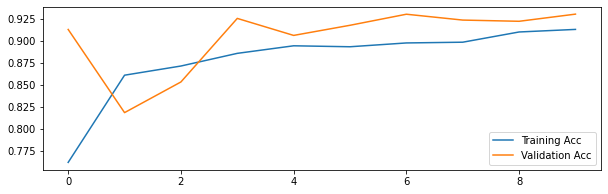

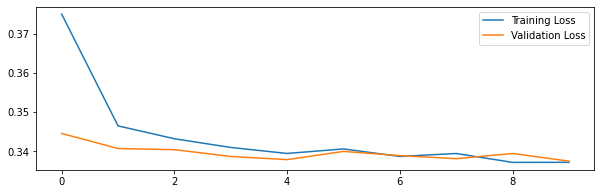

복원 오류 임계치: 5.99165263341991
----------------------------------------------------------------------


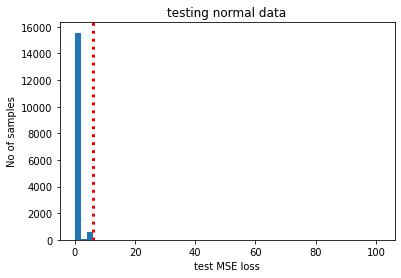

실제 정상중에 불량으로 판단한 갯수 : 2
실제 정상중에 정상으로 판단한 갯수 : 16182
Epoch 1/10
885/885 [==============================] - 3s 2ms/step - loss: 0.4114 - accuracy: 0.7098 - val_loss: 0.3400 - val_accuracy: 0.9216
Epoch 2/10
885/885 [==============================] - 2s 2ms/step - loss: 0.3449 - accuracy: 0.8538 - val_loss: 0.3373 - val_accuracy: 0.9130
Epoch 3/10
885/885 [==============================] - 2s 2ms/step - loss: 0.3389 - accuracy: 0.8652 - val_loss: 0.3363 - val_accuracy: 0.9259
Epoch 4/10
885/885 [==============================] - 2s 2ms/step - loss: 0.3384 - accuracy: 0.8809 - val_loss: 0.3366 - val_accuracy: 0.9315
Epoch 5/10
885/885 [==============================] - 2s 2ms/step - loss: 0.3411 - accuracy: 0.8779 - val_loss: 0.3362 - val_accuracy: 0.9351
Epoch 6/10
885/885 [==============================] - 2s 2ms/step - loss: 0.3401 - accuracy: 0.8722 - val_loss: 0.3380 - val_accuracy: 0.9318
Epoch 7/10
885/885 [==============================] - 2s 2ms/step - loss: 0.3361 - accuracy: 0.8

<Figure size 432x288 with 0 Axes>

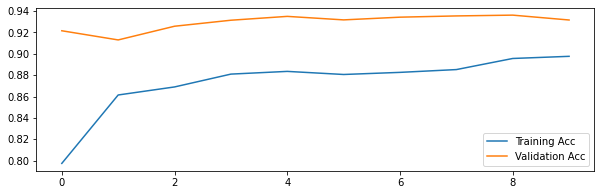

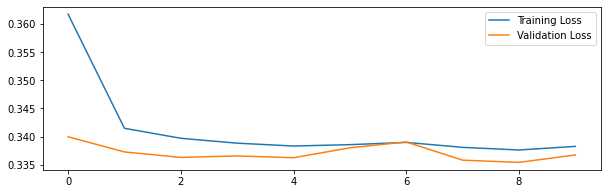

복원 오류 임계치: 5.602649985277133
----------------------------------------------------------------------


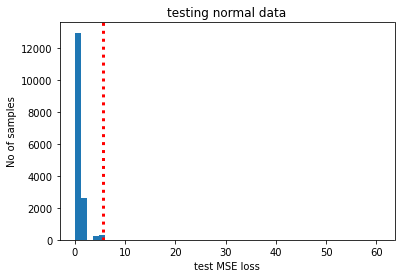

실제 정상중에 불량으로 판단한 갯수 : 10
실제 정상중에 정상으로 판단한 갯수 : 16174
Epoch 1/10
1770/1770 [==============================] - 4s 2ms/step - loss: 0.3868 - accuracy: 0.7327 - val_loss: 0.3374 - val_accuracy: 0.9358
Epoch 2/10
1770/1770 [==============================] - 3s 2ms/step - loss: 0.3447 - accuracy: 0.8877 - val_loss: 0.3371 - val_accuracy: 0.9234
Epoch 3/10
1770/1770 [==============================] - 3s 2ms/step - loss: 0.3446 - accuracy: 0.8984 - val_loss: 0.3366 - val_accuracy: 0.9358
Epoch 4/10
1770/1770 [==============================] - 3s 2ms/step - loss: 0.3411 - accuracy: 0.8967 - val_loss: 0.3452 - val_accuracy: 0.9077
Epoch 5/10
1770/1770 [==============================] - 3s 2ms/step - loss: 0.3400 - accuracy: 0.8815 - val_loss: 0.3420 - val_accuracy: 0.9214
Epoch 6/10
1770/1770 [==============================] - 3s 2ms/step - loss: 0.3422 - accuracy: 0.9039 - val_loss: 0.3363 - val_accuracy: 0.9353
Epoch 7/10
1770/1770 [==============================] - 3s 2ms/step - loss: 0.3372 

<Figure size 432x288 with 0 Axes>

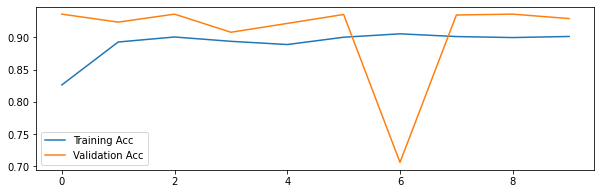

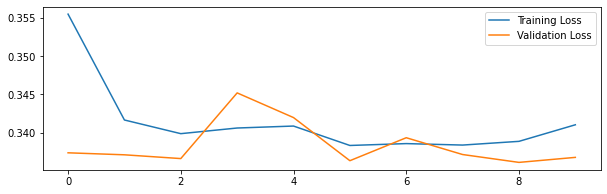

복원 오류 임계치: 68.32846086680124
----------------------------------------------------------------------


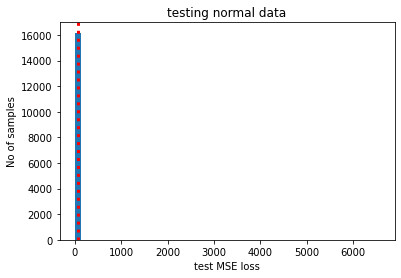

실제 정상중에 불량으로 판단한 갯수 : 1
실제 정상중에 정상으로 판단한 갯수 : 16183
Epoch 1/30
443/443 [==============================] - 2s 2ms/step - loss: 0.4400 - accuracy: 0.6198 - val_loss: 0.3490 - val_accuracy: 0.9207
Epoch 2/30
443/443 [==============================] - 1s 2ms/step - loss: 0.3535 - accuracy: 0.8892 - val_loss: 0.3456 - val_accuracy: 0.9207
Epoch 3/30
443/443 [==============================] - 1s 2ms/step - loss: 0.3473 - accuracy: 0.8977 - val_loss: 0.3455 - val_accuracy: 0.9206
Epoch 4/30
443/443 [==============================] - 1s 2ms/step - loss: 0.3474 - accuracy: 0.8923 - val_loss: 0.3447 - val_accuracy: 0.9230
Epoch 5/30
443/443 [==============================] - 1s 2ms/step - loss: 0.3436 - accuracy: 0.8965 - val_loss: 0.3445 - val_accuracy: 0.8994
Epoch 6/30
443/443 [==============================] - 1s 2ms/step - loss: 0.3470 - accuracy: 0.8965 - val_loss: 0.3437 - val_accuracy: 0.9260
Epoch 7/30
443/443 [==============================] - 1s 2ms/step - loss: 0.3456 - accuracy: 0.9

<Figure size 432x288 with 0 Axes>

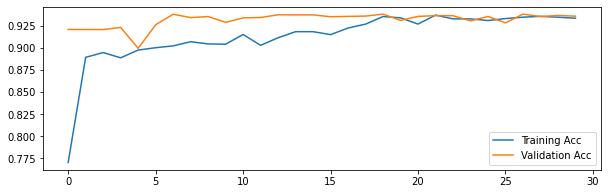

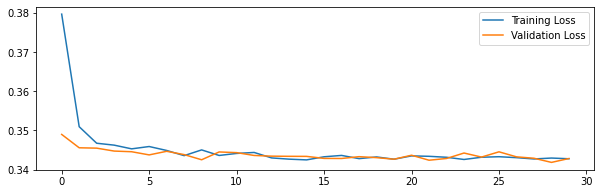

복원 오류 임계치: 21.62135944877445
----------------------------------------------------------------------


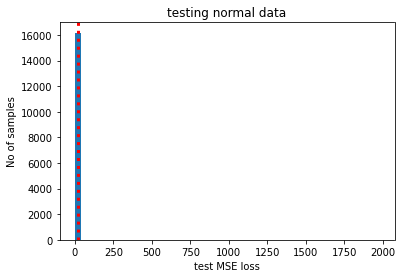

실제 정상중에 불량으로 판단한 갯수 : 2
실제 정상중에 정상으로 판단한 갯수 : 16182
Epoch 1/30
885/885 [==============================] - 2s 2ms/step - loss: 0.3983 - accuracy: 0.7133 - val_loss: 0.3402 - val_accuracy: 0.9165
Epoch 2/30
885/885 [==============================] - 2s 2ms/step - loss: 0.3456 - accuracy: 0.8720 - val_loss: 0.3385 - val_accuracy: 0.9338
Epoch 3/30
885/885 [==============================] - 2s 2ms/step - loss: 0.3393 - accuracy: 0.8835 - val_loss: 0.3374 - val_accuracy: 0.9250
Epoch 4/30
885/885 [==============================] - 2s 2ms/step - loss: 0.3374 - accuracy: 0.8926 - val_loss: 0.3380 - val_accuracy: 0.8508
Epoch 5/30
885/885 [==============================] - 2s 2ms/step - loss: 0.3367 - accuracy: 0.8960 - val_loss: 0.3380 - val_accuracy: 0.9203
Epoch 6/30
885/885 [==============================] - 2s 2ms/step - loss: 0.3382 - accuracy: 0.9027 - val_loss: 0.3382 - val_accuracy: 0.9215
Epoch 7/30
885/885 [==============================] - 2s 2ms/step - loss: 0.3375 - accuracy: 0.9

<Figure size 432x288 with 0 Axes>

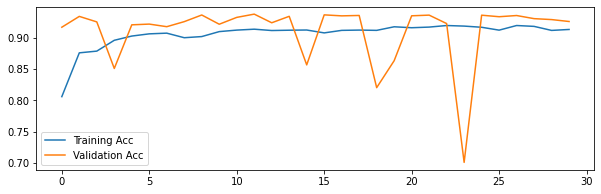

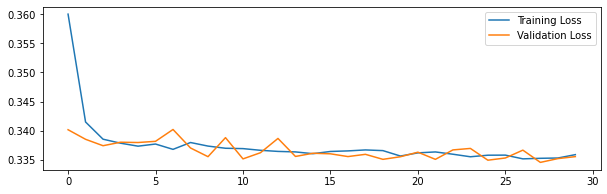

복원 오류 임계치: 39.725561242246826
----------------------------------------------------------------------


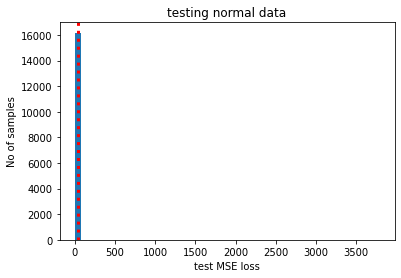

실제 정상중에 불량으로 판단한 갯수 : 1
실제 정상중에 정상으로 판단한 갯수 : 16183
Epoch 1/30
1770/1770 [==============================] - 4s 2ms/step - loss: 0.3829 - accuracy: 0.7504 - val_loss: 0.3404 - val_accuracy: 0.8449
Epoch 2/30
1770/1770 [==============================] - 3s 2ms/step - loss: 0.3457 - accuracy: 0.8660 - val_loss: 0.3385 - val_accuracy: 0.9342
Epoch 3/30
1770/1770 [==============================] - 3s 2ms/step - loss: 0.3420 - accuracy: 0.8757 - val_loss: 0.3389 - val_accuracy: 0.8414
Epoch 4/30
1770/1770 [==============================] - 4s 2ms/step - loss: 0.3415 - accuracy: 0.8937 - val_loss: 0.3366 - val_accuracy: 0.9325
Epoch 5/30
1770/1770 [==============================] - 3s 2ms/step - loss: 0.3356 - accuracy: 0.9067 - val_loss: 0.3380 - val_accuracy: 0.7065
Epoch 6/30
1770/1770 [==============================] - 3s 2ms/step - loss: 0.3397 - accuracy: 0.9035 - val_loss: 0.3385 - val_accuracy: 0.9231
Epoch 7/30
1770/1770 [==============================] - 3s 2ms/step - loss: 0.3402 -

<Figure size 432x288 with 0 Axes>

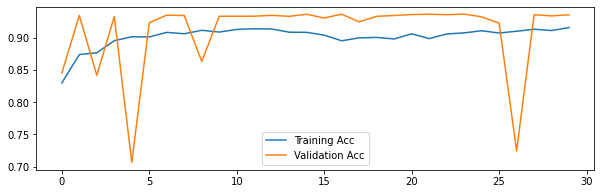

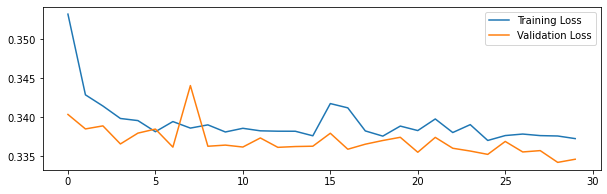

복원 오류 임계치: 87.24782597199275
----------------------------------------------------------------------


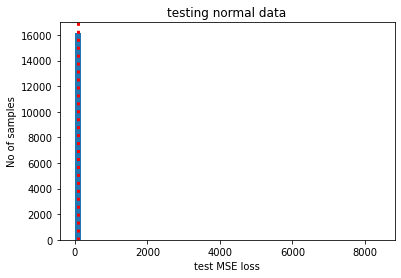

실제 정상중에 불량으로 판단한 갯수 : 1
실제 정상중에 정상으로 판단한 갯수 : 16183
Epoch 1/50
443/443 [==============================] - 2s 2ms/step - loss: 0.4591 - accuracy: 0.6250 - val_loss: 0.3462 - val_accuracy: 0.8966
Epoch 2/50
443/443 [==============================] - 1s 2ms/step - loss: 0.3502 - accuracy: 0.8375 - val_loss: 0.3370 - val_accuracy: 0.9301
Epoch 3/50
443/443 [==============================] - 1s 2ms/step - loss: 0.3439 - accuracy: 0.8556 - val_loss: 0.3361 - val_accuracy: 0.8949
Epoch 4/50
443/443 [==============================] - 1s 2ms/step - loss: 0.3389 - accuracy: 0.8712 - val_loss: 0.3355 - val_accuracy: 0.9302
Epoch 5/50
443/443 [==============================] - 1s 2ms/step - loss: 0.3384 - accuracy: 0.8769 - val_loss: 0.3354 - val_accuracy: 0.9301
Epoch 6/50
443/443 [==============================] - 1s 2ms/step - loss: 0.3370 - accuracy: 0.8993 - val_loss: 0.3366 - val_accuracy: 0.9297
Epoch 7/50
443/443 [==============================] - 1s 2ms/step - loss: 0.3387 - accuracy: 0.9

<Figure size 432x288 with 0 Axes>

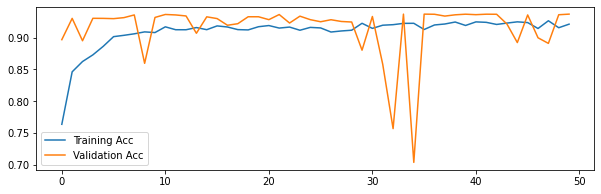

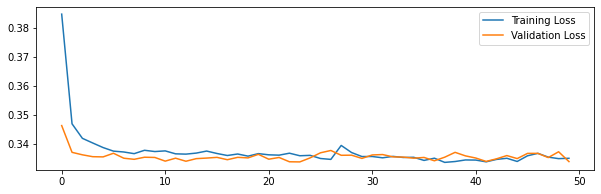

복원 오류 임계치: 9.99115723274982
----------------------------------------------------------------------


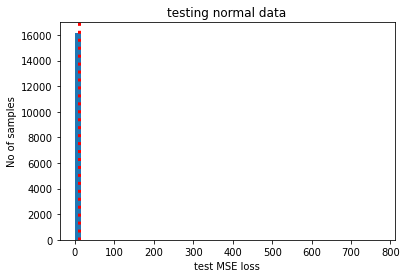

실제 정상중에 불량으로 판단한 갯수 : 2
실제 정상중에 정상으로 판단한 갯수 : 16182
Epoch 1/50
885/885 [==============================] - 2s 2ms/step - loss: 0.4235 - accuracy: 0.6613 - val_loss: 0.3404 - val_accuracy: 0.9257
Epoch 2/50
885/885 [==============================] - 2s 2ms/step - loss: 0.3465 - accuracy: 0.8544 - val_loss: 0.3378 - val_accuracy: 0.9318
Epoch 3/50
885/885 [==============================] - 2s 2ms/step - loss: 0.3410 - accuracy: 0.8800 - val_loss: 0.3416 - val_accuracy: 0.5801
Epoch 4/50
885/885 [==============================] - 2s 2ms/step - loss: 0.3401 - accuracy: 0.8654 - val_loss: 0.3366 - val_accuracy: 0.9294
Epoch 5/50
885/885 [==============================] - 2s 2ms/step - loss: 0.3374 - accuracy: 0.8803 - val_loss: 0.3368 - val_accuracy: 0.9299
Epoch 6/50
885/885 [==============================] - 2s 2ms/step - loss: 0.3385 - accuracy: 0.8939 - val_loss: 0.3376 - val_accuracy: 0.9200
Epoch 7/50
885/885 [==============================] - 2s 2ms/step - loss: 0.3411 - accuracy: 0.9

<Figure size 432x288 with 0 Axes>

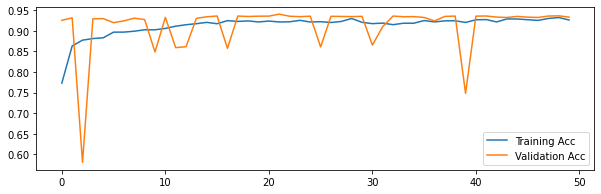

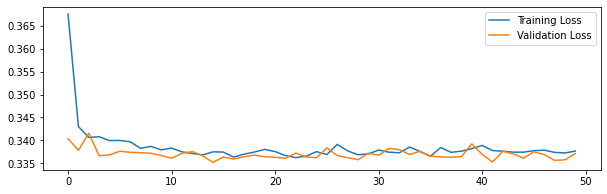

복원 오류 임계치: 65.45694267071633
----------------------------------------------------------------------


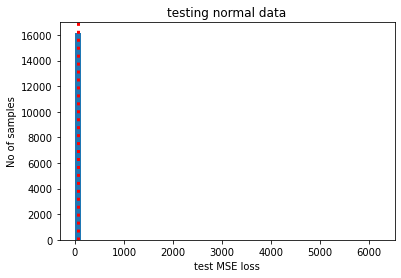

실제 정상중에 불량으로 판단한 갯수 : 1
실제 정상중에 정상으로 판단한 갯수 : 16183
Epoch 1/50
1770/1770 [==============================] - 4s 2ms/step - loss: 0.3886 - accuracy: 0.7709 - val_loss: 0.3389 - val_accuracy: 0.9199
Epoch 2/50
1770/1770 [==============================] - 3s 2ms/step - loss: 0.3381 - accuracy: 0.8622 - val_loss: 0.3385 - val_accuracy: 0.7160
Epoch 3/50
1770/1770 [==============================] - 3s 2ms/step - loss: 0.3405 - accuracy: 0.8652 - val_loss: 0.3402 - val_accuracy: 0.9183
Epoch 4/50
1770/1770 [==============================] - 3s 2ms/step - loss: 0.3423 - accuracy: 0.8883 - val_loss: 0.3370 - val_accuracy: 0.9245
Epoch 5/50
1770/1770 [==============================] - 3s 2ms/step - loss: 0.3384 - accuracy: 0.8899 - val_loss: 0.3373 - val_accuracy: 0.9231
Epoch 6/50
1770/1770 [==============================] - 3s 2ms/step - loss: 0.3392 - accuracy: 0.8863 - val_loss: 0.3393 - val_accuracy: 0.9218
Epoch 7/50
1770/1770 [==============================] - 3s 2ms/step - loss: 0.3401 -

<Figure size 432x288 with 0 Axes>

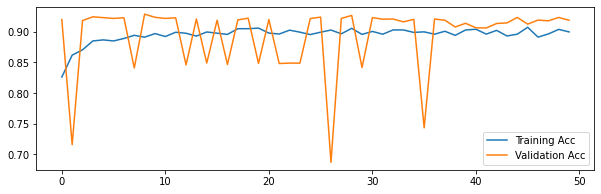

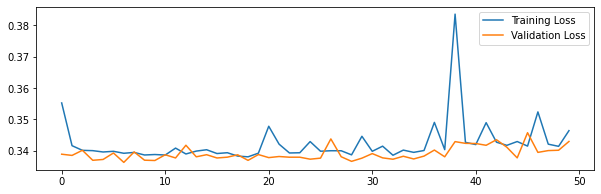

복원 오류 임계치: 79.78371698956792
----------------------------------------------------------------------


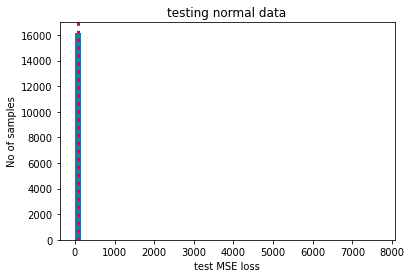

실제 정상중에 불량으로 판단한 갯수 : 1
실제 정상중에 정상으로 판단한 갯수 : 16183


In [188]:
epochs=[10,30,50]
batch_size = [64,32,16]
for epoch in epochs:
  for batch in batch_size:
    train(x_train, x_test,epoch,batch)

### 2-4.1) Building Model - RG3

In [190]:
rg3_xx = pd.merge(rg3_x,moldset_unlabeled_rg3,how='outer')
rg3_x2 = rg3_xx['Mold_Temperature_4']
rg3_xx = rg3_xx.values
rg3_xx = np.array(rg3_xx)
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(rg3_xx, rg3_x2, test_size=0.3)

### 2-4.2) Checking Model - RG3

Epoch 1/10
1268/1268 [==============================] - 3s 2ms/step - loss: 0.4210 - accuracy: 0.4644 - val_loss: 0.3662 - val_accuracy: 0.7524
Epoch 2/10
1268/1268 [==============================] - 2s 2ms/step - loss: 0.3705 - accuracy: 0.5914 - val_loss: 0.3653 - val_accuracy: 0.6345
Epoch 3/10
1268/1268 [==============================] - 2s 2ms/step - loss: 0.3666 - accuracy: 0.5857 - val_loss: 0.3655 - val_accuracy: 0.4099
Epoch 4/10
1268/1268 [==============================] - 2s 2ms/step - loss: 0.3680 - accuracy: 0.5962 - val_loss: 0.3679 - val_accuracy: 0.5366
Epoch 5/10
1268/1268 [==============================] - 2s 2ms/step - loss: 0.3642 - accuracy: 0.6041 - val_loss: 0.3669 - val_accuracy: 0.5410
Epoch 6/10
1268/1268 [==============================] - 2s 2ms/step - loss: 0.3646 - accuracy: 0.6054 - val_loss: 0.3667 - val_accuracy: 0.5539
Epoch 7/10
1268/1268 [==============================] - 2s 2ms/step - loss: 0.3693 - accuracy: 0.6173 - val_loss: 0.3660 - val_accuracy:

<Figure size 432x288 with 0 Axes>

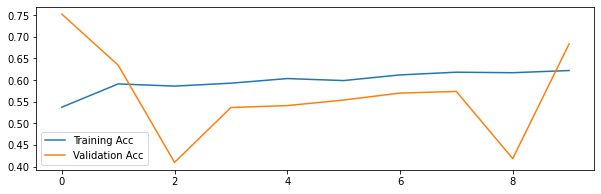

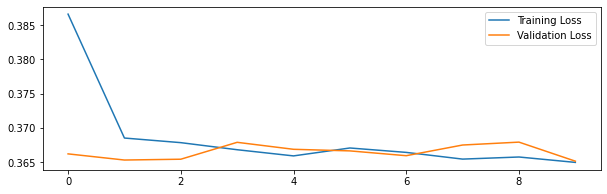

복원 오류 임계치: 38.099316876043
----------------------------------------------------------------------


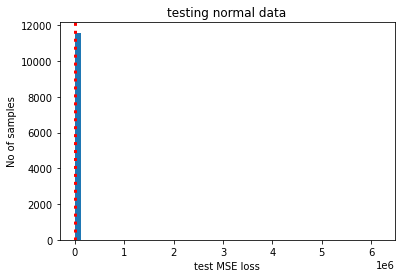

실제 정상중에 불량으로 판단한 갯수 : 10
실제 정상중에 정상으로 판단한 갯수 : 11581
Epoch 1/10
634/634 [==============================] - 2s 2ms/step - loss: 0.4364 - accuracy: 0.4334 - val_loss: 0.3644 - val_accuracy: 0.5687
Epoch 2/10
634/634 [==============================] - 1s 2ms/step - loss: 0.3712 - accuracy: 0.5682 - val_loss: 0.3648 - val_accuracy: 0.5919
Epoch 3/10
634/634 [==============================] - 1s 2ms/step - loss: 0.3635 - accuracy: 0.6097 - val_loss: 0.3672 - val_accuracy: 0.6285
Epoch 4/10
634/634 [==============================] - 1s 2ms/step - loss: 0.3670 - accuracy: 0.6294 - val_loss: 0.3673 - val_accuracy: 0.6650
Epoch 5/10
634/634 [==============================] - 1s 2ms/step - loss: 0.3605 - accuracy: 0.6444 - val_loss: 0.3664 - val_accuracy: 0.6197
Epoch 6/10
634/634 [==============================] - 1s 2ms/step - loss: 0.3618 - accuracy: 0.6705 - val_loss: 0.3603 - val_accuracy: 0.6080
Epoch 7/10
634/634 [==============================] - 1s 2ms/step - loss: 0.3575 - accuracy: 0.

<Figure size 432x288 with 0 Axes>

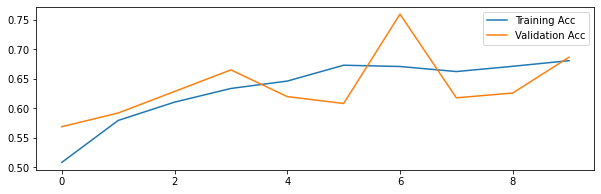

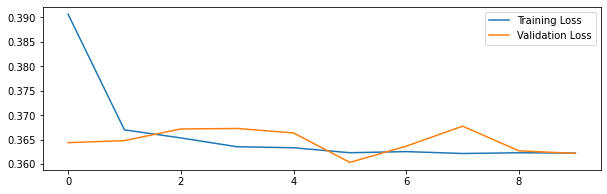

복원 오류 임계치: 35.94697247881311
----------------------------------------------------------------------


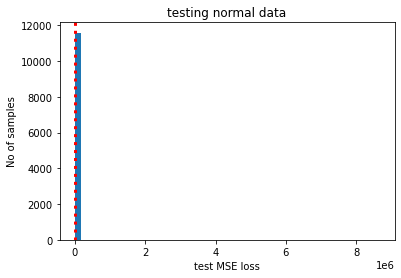

실제 정상중에 불량으로 판단한 갯수 : 6
실제 정상중에 정상으로 판단한 갯수 : 11585
Epoch 1/10
317/317 [==============================] - 2s 3ms/step - loss: 0.4706 - accuracy: 0.3748 - val_loss: 0.3782 - val_accuracy: 0.6234
Epoch 2/10
317/317 [==============================] - 1s 2ms/step - loss: 0.3859 - accuracy: 0.5458 - val_loss: 0.3738 - val_accuracy: 0.5836
Epoch 3/10
317/317 [==============================] - 1s 2ms/step - loss: 0.3808 - accuracy: 0.5617 - val_loss: 0.3726 - val_accuracy: 0.5001
Epoch 4/10
317/317 [==============================] - 1s 2ms/step - loss: 0.3790 - accuracy: 0.5970 - val_loss: 0.3745 - val_accuracy: 0.5396
Epoch 5/10
317/317 [==============================] - 1s 2ms/step - loss: 0.3703 - accuracy: 0.5981 - val_loss: 0.3731 - val_accuracy: 0.6052
Epoch 6/10
317/317 [==============================] - 1s 2ms/step - loss: 0.3732 - accuracy: 0.6131 - val_loss: 0.3762 - val_accuracy: 0.6864
Epoch 7/10
317/317 [==============================] - 1s 2ms/step - loss: 0.3704 - accuracy: 0.6

<Figure size 432x288 with 0 Axes>

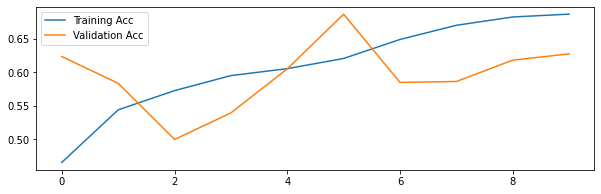

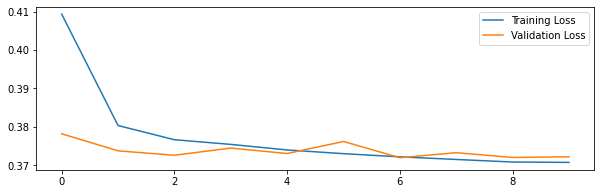

복원 오류 임계치: 34.59820836302295
----------------------------------------------------------------------


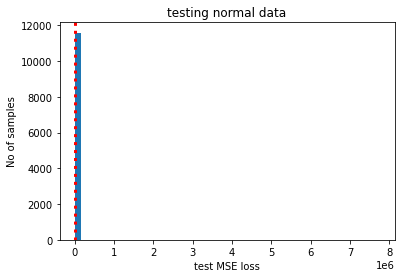

실제 정상중에 불량으로 판단한 갯수 : 5
실제 정상중에 정상으로 판단한 갯수 : 11586
Epoch 1/30
1268/1268 [==============================] - 3s 2ms/step - loss: 0.4193 - accuracy: 0.4466 - val_loss: 0.3650 - val_accuracy: 0.5909
Epoch 2/30
1268/1268 [==============================] - 2s 2ms/step - loss: 0.3654 - accuracy: 0.5669 - val_loss: 0.3626 - val_accuracy: 0.7293
Epoch 3/30
1268/1268 [==============================] - 2s 2ms/step - loss: 0.3595 - accuracy: 0.6376 - val_loss: 0.3627 - val_accuracy: 0.6446
Epoch 4/30
1268/1268 [==============================] - 2s 2ms/step - loss: 0.3632 - accuracy: 0.6721 - val_loss: 0.3632 - val_accuracy: 0.6400
Epoch 5/30
1268/1268 [==============================] - 2s 2ms/step - loss: 0.3614 - accuracy: 0.6866 - val_loss: 0.3636 - val_accuracy: 0.5989
Epoch 6/30
1268/1268 [==============================] - 2s 2ms/step - loss: 0.3623 - accuracy: 0.6883 - val_loss: 0.3637 - val_accuracy: 0.6265
Epoch 7/30
1268/1268 [==============================] - 2s 2ms/step - loss: 0.3594 -

<Figure size 432x288 with 0 Axes>

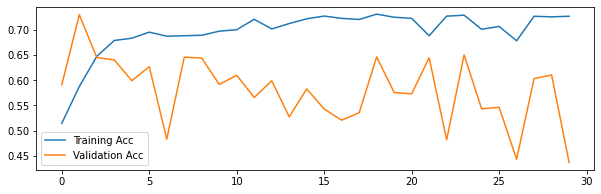

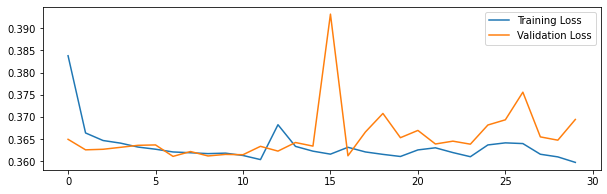

복원 오류 임계치: 33.00488956831284
----------------------------------------------------------------------


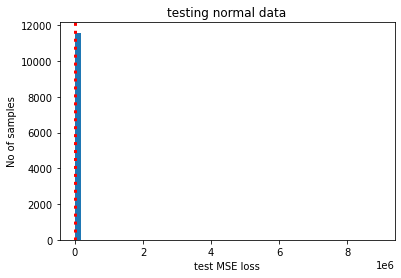

실제 정상중에 불량으로 판단한 갯수 : 9
실제 정상중에 정상으로 판단한 갯수 : 11582
Epoch 1/30
634/634 [==============================] - 2s 2ms/step - loss: 0.4496 - accuracy: 0.4193 - val_loss: 0.3704 - val_accuracy: 0.4553
Epoch 2/30
634/634 [==============================] - 1s 2ms/step - loss: 0.3734 - accuracy: 0.5720 - val_loss: 0.3656 - val_accuracy: 0.5601
Epoch 3/30
634/634 [==============================] - 1s 2ms/step - loss: 0.3662 - accuracy: 0.5582 - val_loss: 0.3654 - val_accuracy: 0.5725
Epoch 4/30
634/634 [==============================] - 1s 2ms/step - loss: 0.3636 - accuracy: 0.5624 - val_loss: 0.3645 - val_accuracy: 0.5779
Epoch 5/30
634/634 [==============================] - 1s 2ms/step - loss: 0.3669 - accuracy: 0.5760 - val_loss: 0.3652 - val_accuracy: 0.5289
Epoch 6/30
634/634 [==============================] - 1s 2ms/step - loss: 0.3675 - accuracy: 0.5914 - val_loss: 0.3638 - val_accuracy: 0.5007
Epoch 7/30
634/634 [==============================] - 1s 2ms/step - loss: 0.3685 - accuracy: 0.6

<Figure size 432x288 with 0 Axes>

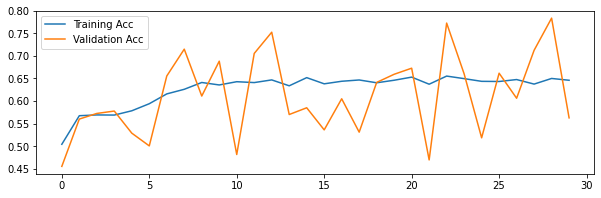

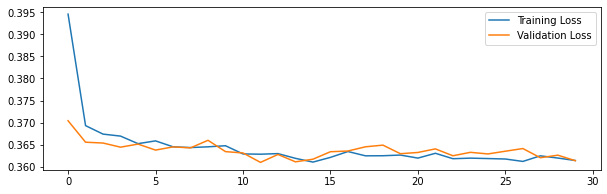

복원 오류 임계치: 32.90592404703418
----------------------------------------------------------------------


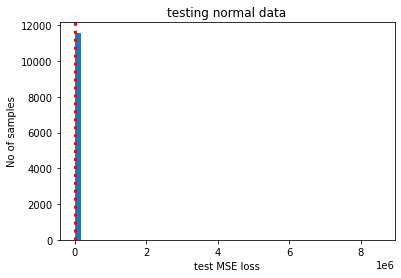

실제 정상중에 불량으로 판단한 갯수 : 5
실제 정상중에 정상으로 판단한 갯수 : 11586
Epoch 1/30
317/317 [==============================] - 1s 2ms/step - loss: 0.4615 - accuracy: 0.4186 - val_loss: 0.3648 - val_accuracy: 0.6532
Epoch 2/30
317/317 [==============================] - 1s 2ms/step - loss: 0.3693 - accuracy: 0.5817 - val_loss: 0.3620 - val_accuracy: 0.5934
Epoch 3/30
317/317 [==============================] - 1s 2ms/step - loss: 0.3681 - accuracy: 0.6104 - val_loss: 0.3661 - val_accuracy: 0.5742
Epoch 4/30
317/317 [==============================] - 1s 2ms/step - loss: 0.3660 - accuracy: 0.6176 - val_loss: 0.3632 - val_accuracy: 0.5967
Epoch 5/30
317/317 [==============================] - 1s 2ms/step - loss: 0.3575 - accuracy: 0.6286 - val_loss: 0.3667 - val_accuracy: 0.5486
Epoch 6/30
317/317 [==============================] - 1s 2ms/step - loss: 0.3594 - accuracy: 0.6317 - val_loss: 0.3640 - val_accuracy: 0.5742
Epoch 7/30
317/317 [==============================] - 1s 2ms/step - loss: 0.3607 - accuracy: 0.6

<Figure size 432x288 with 0 Axes>

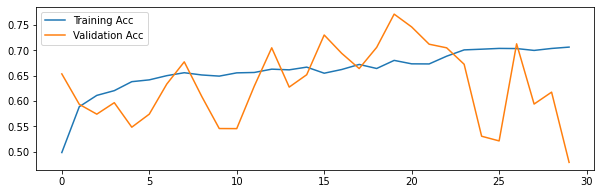

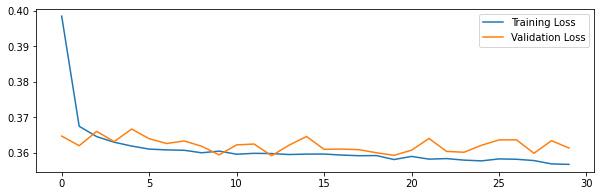

복원 오류 임계치: 32.48948850796605
----------------------------------------------------------------------


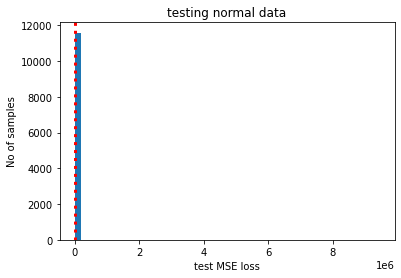

실제 정상중에 불량으로 판단한 갯수 : 6
실제 정상중에 정상으로 판단한 갯수 : 11585
Epoch 1/50
1268/1268 [==============================] - 3s 2ms/step - loss: 0.4235 - accuracy: 0.4109 - val_loss: 0.3712 - val_accuracy: 0.6193
Epoch 2/50
1268/1268 [==============================] - 2s 2ms/step - loss: 0.3714 - accuracy: 0.5725 - val_loss: 0.3676 - val_accuracy: 0.5585
Epoch 3/50
1268/1268 [==============================] - 2s 2ms/step - loss: 0.3754 - accuracy: 0.5917 - val_loss: 0.3691 - val_accuracy: 0.4964
Epoch 4/50
1268/1268 [==============================] - 2s 2ms/step - loss: 0.3723 - accuracy: 0.5916 - val_loss: 0.3695 - val_accuracy: 0.4381
Epoch 5/50
1268/1268 [==============================] - 2s 2ms/step - loss: 0.3760 - accuracy: 0.6124 - val_loss: 0.3690 - val_accuracy: 0.5838
Epoch 6/50
1268/1268 [==============================] - 2s 2ms/step - loss: 0.3721 - accuracy: 0.5947 - val_loss: 0.3702 - val_accuracy: 0.6313
Epoch 7/50
1268/1268 [==============================] - 2s 2ms/step - loss: 0.3682 -

<Figure size 432x288 with 0 Axes>

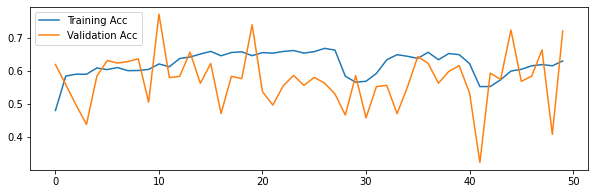

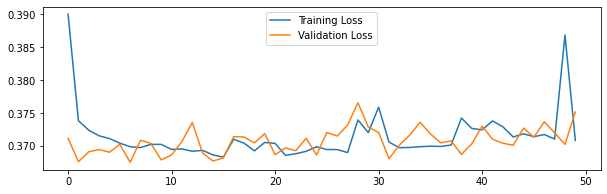

복원 오류 임계치: 36.777125105496644
----------------------------------------------------------------------


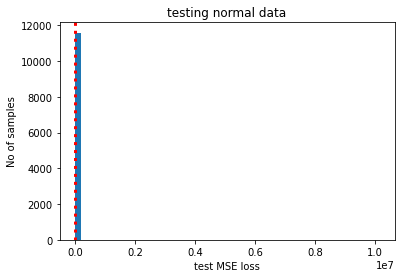

실제 정상중에 불량으로 판단한 갯수 : 10
실제 정상중에 정상으로 판단한 갯수 : 11581
Epoch 1/50
634/634 [==============================] - 2s 2ms/step - loss: 0.4470 - accuracy: 0.4037 - val_loss: 0.3630 - val_accuracy: 0.5027
Epoch 2/50
634/634 [==============================] - 1s 2ms/step - loss: 0.3694 - accuracy: 0.5861 - val_loss: 0.3603 - val_accuracy: 0.7468
Epoch 3/50
634/634 [==============================] - 1s 2ms/step - loss: 0.3651 - accuracy: 0.6202 - val_loss: 0.3611 - val_accuracy: 0.5859
Epoch 4/50
634/634 [==============================] - 1s 2ms/step - loss: 0.3687 - accuracy: 0.6382 - val_loss: 0.3621 - val_accuracy: 0.6986
Epoch 5/50
634/634 [==============================] - 1s 2ms/step - loss: 0.3691 - accuracy: 0.6429 - val_loss: 0.3615 - val_accuracy: 0.5690
Epoch 6/50
634/634 [==============================] - 1s 2ms/step - loss: 0.3594 - accuracy: 0.6379 - val_loss: 0.3598 - val_accuracy: 0.5477
Epoch 7/50
634/634 [==============================] - 1s 2ms/step - loss: 0.3642 - accuracy: 0.

<Figure size 432x288 with 0 Axes>

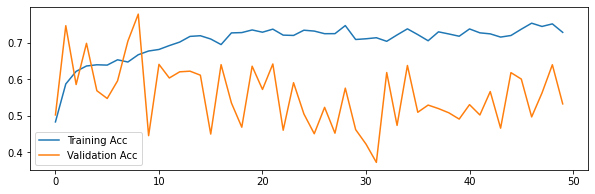

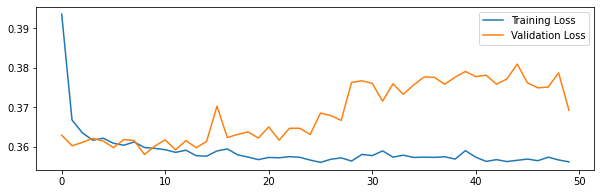

복원 오류 임계치: 33.20900870004233
----------------------------------------------------------------------


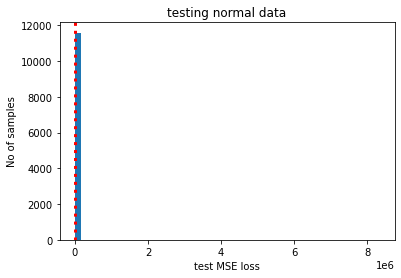

실제 정상중에 불량으로 판단한 갯수 : 5
실제 정상중에 정상으로 판단한 갯수 : 11586
Epoch 1/50
317/317 [==============================] - 1s 2ms/step - loss: 0.4651 - accuracy: 0.3743 - val_loss: 0.3637 - val_accuracy: 0.6595
Epoch 2/50
317/317 [==============================] - 1s 2ms/step - loss: 0.3702 - accuracy: 0.5719 - val_loss: 0.3615 - val_accuracy: 0.6533
Epoch 3/50
317/317 [==============================] - 1s 2ms/step - loss: 0.3674 - accuracy: 0.6020 - val_loss: 0.3617 - val_accuracy: 0.5798
Epoch 4/50
317/317 [==============================] - 1s 2ms/step - loss: 0.3670 - accuracy: 0.6060 - val_loss: 0.3613 - val_accuracy: 0.5714
Epoch 5/50
317/317 [==============================] - 1s 2ms/step - loss: 0.3608 - accuracy: 0.6120 - val_loss: 0.3598 - val_accuracy: 0.6100
Epoch 6/50
317/317 [==============================] - 1s 2ms/step - loss: 0.3631 - accuracy: 0.6158 - val_loss: 0.3604 - val_accuracy: 0.6038
Epoch 7/50
317/317 [==============================] - 1s 2ms/step - loss: 0.3642 - accuracy: 0.6

<Figure size 432x288 with 0 Axes>

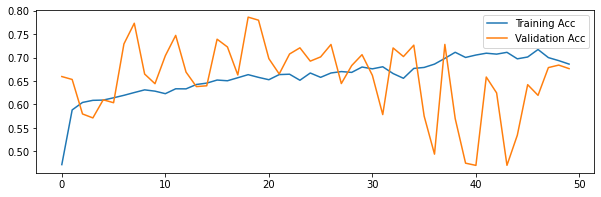

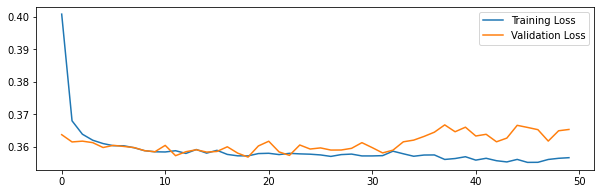

복원 오류 임계치: 37.86363906353725
----------------------------------------------------------------------


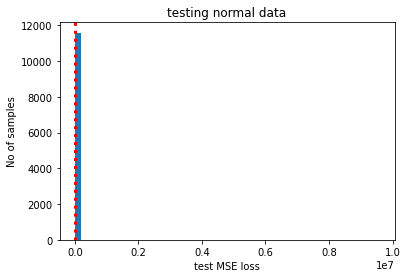

실제 정상중에 불량으로 판단한 갯수 : 10
실제 정상중에 정상으로 판단한 갯수 : 11581


In [196]:
model_rg3 = base_autoencoder(x_train_2, x_test_2)
epochs=[10,30,50]
batch_size = [16,32,64]
for epoch in epochs:
  for batch in batch_size:
    train(x_train_2, x_test_2,epoch,batch)